## Stock Price Prediction

In [1]:
#import libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math 
import tensorflow
import seaborn as sns
from tensorflow import keras
from keras import layers , Sequential
from keras.layers import  Dense,LSTM,Flatten,Input,Dropout,TimeDistributed,RepeatVector
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import  mean_squared_error

In [2]:
# Loading data 
data = pd.read_csv(r'E:\Data Science\RNN-LSTM\GE.csv')

# Inspecting data shape 
data.shape

(5030, 7)

In [3]:
# Converting dates 
train_dates = pd.to_datetime(data['Date'])
train_dates

0      2001-06-11
1      2001-06-12
2      2001-06-13
3      2001-06-14
4      2001-06-15
          ...    
5025   2021-06-02
5026   2021-06-03
5027   2021-06-04
5028   2021-06-07
5029   2021-06-08
Name: Date, Length: 5030, dtype: datetime64[ns]

In [5]:
cols=list(data)[1:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [8]:

df_training = data[cols].astype(dtype=float)
list(df_training)
df_training.head()

,Open,High,Low,Close,Adj Close
0,368.076935,376.538452,363.230774,364.615387,203.947662
1,364.615387,379.000000,355.846161,375.153839,209.842361
2,370.000000,379.153839,366.923065,368.076935,205.883896
3,375.153839,386.230774,368.076935,375.846161,210.229675
4,371.538452,379.615387,369.230774,375.461548,210.014481


In [99]:
# rescaling the features 
scaler = StandardScaler()
df_for_training_scaled = scaler.fit_transform(df_training)
df_for_training_scaled.shape[1]

5

In [38]:
# Splitting data  
trainX =[]
trainY=[]
future = 1 # number of days to predict into the next future
past= 14 # number of past days data to predict the future 


# splitting data into trainX and trainY
for i in range(past, len(df_for_training_scaled)):
    trainX.append(df_for_training_scaled[i-past:i,  0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i+future-1:i+future,0])

trainX, trainY = np.array(trainX), np.array(trainY)

print(f'trainX shape: {trainX.shape}')

print(f'trainX shape: {trainX.shape}')

trainX shape: (5016, 14, 5)
trainX shape: (5016, 1)


## Creating and fitting the LSTM stack model

In [40]:

model = Sequential(
    [LSTM(64,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True),
     LSTM (units=6, activation='relu', return_sequences=False),
     Dropout(0.2),
     Dense(trainY.shape[1])]
     
)

model.compile(
    loss='mse',
    optimizer='adam'
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_3 (LSTM)               (None, 6)                 1704      
                                                                 
 dropout_1 (Dropout)         (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 19,631
Trainable params: 19,631
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(trainX,trainY, epochs=15, batch_size =5, validation_split=0.1, verbose=1)


Epoch 1/15
903/903 [==============================] - 17s 19ms/step - loss: 0.0715 - val_loss: 0.0264
Epoch 2/15
903/903 [==============================] - 18s 20ms/step - loss: 0.0659 - val_loss: 0.0188
Epoch 3/15
903/903 [==============================] - 13s 14ms/step - loss: 0.0625 - val_loss: 0.0165
Epoch 4/15
903/903 [==============================] - 17s 19ms/step - loss: 0.0661 - val_loss: 0.0262
Epoch 5/15
903/903 [==============================] - 16s 18ms/step - loss: 0.0657 - val_loss: 0.0122
Epoch 6/15
903/903 [==============================] - 11s 13ms/step - loss: 0.0690 - val_loss: 0.0166
Epoch 7/15
903/903 [==============================] - 11s 12ms/step - loss: 0.0619 - val_loss: 0.0443
Epoch 8/15
903/903 [==============================] - 11s 12ms/step - loss: 0.0677 - val_loss: 0.0167
Epoch 9/15
903/903 [==============================] - 11s 12ms/step - loss: 0.0644 - val_loss: 0.0559
Epoch 10/15
903/903 [==============================] - 11s 12ms/step - loss: 0.065

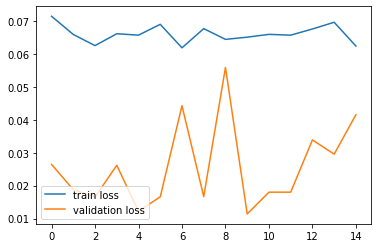

In [60]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'], label= 'validation loss')
plt.legend(loc='lower left')

In [109]:
# forcasting the stock price for the next ninety days 
n_future = 90

forecast_period = pd.date_range(start=list(train_dates)[-1], periods= n_future, freq ='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast


3/3 [==============================] - 0s 7ms/step


In [110]:
forecast_copies = np.repeat(forecast, df_training.shape[1], axis=-1)
y_predict_future = scaler.inverse_transform(forecast_copies)[:,0]
# y_predict_future[0]


In [111]:
forecast_dates= []
for time in forecast_period:
    forecast_dates.append(time.date())


df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_predict_future})

df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [112]:
original = data[['Date','Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date']>='2020-05-1']

C:\Users\colombia\AppData\Local\Temp\ipykernel_13204\3296328717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


c:\Users\colombia\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\colombia\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Open'>

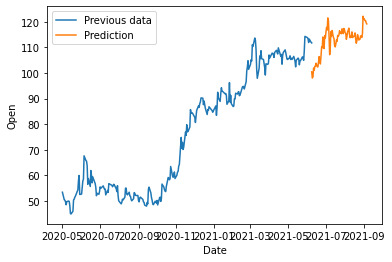

In [98]:
sns.lineplot(original['Date'], original['Open'],label='Previous data')
sns.lineplot(df_forecast['Date'], df_forecast['Open'],label='Prediction')